In [7]:
import shutil
import os
    
source_dir = 'datasets_labeled'  
file_names = os.listdir(source_dir)
file_names = [file for file in file_names if file.endswith('.xlsx')]

for ind, filename in enumerate(file_names):
    target_dir = "datasets_labeled/removed/missing_"+ os.path.splitext(filename)[0] +"/"
    os.makedirs(target_dir)
    for index, file_name in enumerate(file_names):
        if index != ind:
            shutil.copy(os.path.join(source_dir, file_name), target_dir)
 
n = 0
for ind, filename in enumerate(file_names):
    target_dir = "datasets/removed/missing_"+ os.path.splitext(filename)[0] +"/"
    os.makedirs(target_dir)
    n = n+1
        
   

In [8]:
import os
rootdir = 'datasets_labeled/removed'

for [subdir, dirs, files], [subdir1, dirs1, files1] in zip(os.walk(rootdir), os.walk('datasets/removed')):
    print(subdir, str(subdir1))
        

datasets_labeled/removed datasets/removed
datasets_labeled/removed\missing_accuracy datasets/removed\missing_accuracy
datasets_labeled/removed\missing_alarm datasets/removed\missing_alarm
datasets_labeled/removed\missing_application_process datasets/removed\missing_application_process
datasets_labeled/removed\missing_asset datasets/removed\missing_asset
datasets_labeled/removed\missing_audit datasets/removed\missing_audit
datasets_labeled/removed\missing_ball grid array datasets/removed\missing_ball grid array
datasets_labeled/removed\missing_bus coupler datasets/removed\missing_bus coupler
datasets_labeled/removed\missing_client datasets/removed\missing_client
datasets_labeled/removed\missing_confidentiality datasets/removed\missing_confidentiality
datasets_labeled/removed\missing_device datasets/removed\missing_device
datasets_labeled/removed\missing_diversity datasets/removed\missing_diversity
datasets_labeled/removed\missing_domain datasets/removed\missing_domain
datasets_labeled/r

In [9]:
def get_all_pairs_from_file(directory, filename):
    term = filename.split('.')[0]
    df_rawgroups = read_excel(directory + filename, sheet_name="groups", index_col=None, header=None, engine='openpyxl')
    df_rawgroups = df_rawgroups.drop(df_rawgroups.columns[[0, 1]], axis=1)  # removing first and third unwanted column
    df_rawgroups = df_rawgroups.drop([0, 1])  # removing first and third unwanted column

    df_group_similarities = read_excel(directory + filename, sheet_name="group similarities", index_col=None, header=None, engine='openpyxl')
    df_group_similarities = df_group_similarities.drop(0, axis=0)
    df_group_similarities = df_group_similarities.drop(0, axis=1)

    df_definition = df_rawgroups[df_rawgroups.columns[range(0, df_rawgroups.shape[1]-1, 4)]]

    groups = []
    for column in df_definition.columns:
        group = []
        for definition in df_definition[column]: 
            if not pd.isna(definition): group.append(definition)
        groups.append(group)    
        pairs = []

    for grp_index1, group1 in enumerate(groups):
        for definition1 in group1:
            for grp_index2, group2 in enumerate(groups):
                for definition2 in group2:
                    if definition1 is not definition2:
                        sim = df_group_similarities.iloc[grp_index1,grp_index2]
                        if type(sim) is str: sim = sim.upper() 
                        if len(str(sim)) == 1 and (grp_index1 <= grp_index2) and not pd.isna(sim): 
                            pairs.append([term, term + str(grp_index1), term + str(grp_index2), definition1, definition2, sim])
    return pairs

def generationProcess(dataset_size, directory,loc_generated_devset,loc_generated_trainset,loc_generated_testset):
    pairs = []                  
    for filename in os.listdir(directory):
        if not filename.startswith("~") and filename.endswith(".xlsx"):
            print(os.path.join(directory, filename))
            pairs.extend(get_all_pairs_from_file(directory, filename))
        else:
            continue

    df_pairs = pd.DataFrame(pairs, columns=["term", "grp_id1", "grp_id2", "definition1", "definition2", "sim"])
    
    print(90*'=')
    print("Datenset zusammenstellen: Möglichst ausgeglichene Anzahl von similarity labels,\nBenennungen und Begriffsgruppen erstellen")
    print(90*'=' + "\n")

    df = df_pairs.copy(deep=True)
    df.insert(df.shape[1], "count_sim", [0]*df.shape[0], True) 
    df.insert(df.shape[1], "count_term", [0]*df.shape[0], True) 
    df.insert(df.shape[1], "count_grpid1", [0]*df.shape[0], True) 
    df.insert(df.shape[1], "count_grpid2", [0]*df.shape[0], True) 
    df.insert(df.shape[1], "count_def", [0]*df.shape[0], True) 

    df_dataset = pd.DataFrame(columns=df.columns)

    for i in range (0, dataset_size):
        #erstes Paar auswählen und entfernen
        if len(df) == 0:
            continue
        select = df.iloc[0]
        df_dataset = df_dataset.append(select)
        df.drop(select.name, inplace=True, errors='raise')

        #eigenschaften hochzählen
        df.loc[df.sim == select.sim, 'count_sim'] += 1
        df.loc[df.term == select.term, 'count_term'] += 1
        df.loc[df.grp_id1 == select.grp_id1, 'count_grpid1'] += 1
        df.loc[df.grp_id1 == select.grp_id2, 'count_grpid2'] += 1
        df.loc[df.grp_id2 == select.grp_id1, 'count_grpid1'] += 1
        df.loc[df.grp_id2 == select.grp_id2, 'count_grpid2'] += 1
        df.loc[df.definition1 == select.definition1, 'count_def'] += 1
        df.loc[df.definition1 == select.definition2, 'count_def'] += 1
        df.loc[df.definition2 == select.definition1, 'count_def'] += 1
        df.loc[df.definition2 == select.definition2, 'count_def'] += 1

        #sortieren, so dass Paare mit Eigenschaften, die am seltensten vertreten sind, oben stehen 
        df.sort_values(by=['count_sim','count_def','count_grpid1','count_grpid2','count_term'], inplace=True)


    #Verteilung ausgeben
    print(df_dataset.groupby(['sim']).size())
    print('')
    print(df_dataset.groupby(['term']).size())
    
    print(90*'=')
    print("Datenset speichern")
    print(90*'=' + "\n")
    from sklearn.model_selection import train_test_split

    testset_terms = ["domain", "hazard", "group", "event"]

    train_df = df_dataset[~df_dataset["term"].isin(testset_terms)]
    test_df = df_dataset[df_dataset["term"].isin(testset_terms)]
    test_df.to_csv(loc_generated_testset)


    train, dev = train_test_split(train_df, test_size=0.2)
    train.to_csv(loc_generated_trainset)
    dev.to_csv(loc_generated_devset)

    #for term in df_dataset["term"].unique():
    #    df_dataset[df_dataset["term"] == term].to_csv("datasets_by_term/"+term+".csv")
        
    #test_df
    
    #train_df[train_df["term"]=="client"]
    
    


In [10]:
import csv
from itertools import product
from pandas import read_excel
import numpy as np
import pandas as pd
import os

# Number of pairs
dataset_size = 7000

rootdir = 'datasets_labeled/removed/'
generated_dataset_dir = 'datasets/removed/'
count = 0

for subdir1, dirs1, files1 in os.walk(generated_dataset_dir):
    if subdir1 != generated_dataset_dir and not subdir1.endswith(".ipynb_checkpoints"):
        directory = rootdir+subdir1[17:]+"/"

        print(90*'=')
        print("Generating dataset in directory: " + subdir1 + "--> "+str(count+1)+"/"+str(n))
        print(90*'=' + "\n")
    
        loc_generated_devset = subdir1 + "/dev_set.csv"
        loc_generated_trainset = subdir1 + "/train_set.csv"
        loc_generated_testset = subdir1 + "/test_set.csv"
        
        generationProcess(dataset_size, directory,loc_generated_devset,loc_generated_trainset,loc_generated_testset)
        
        count=count+1


Generating dataset in directory: datasets/removed/missing_accuracy--> 1/40

datasets_labeled/removed/missing_accuracy/alarm.xlsx
datasets_labeled/removed/missing_accuracy/application_process.xlsx
datasets_labeled/removed/missing_accuracy/asset.xlsx
datasets_labeled/removed/missing_accuracy/audit.xlsx
datasets_labeled/removed/missing_accuracy/ball grid array.xlsx
datasets_labeled/removed/missing_accuracy/bus coupler.xlsx
datasets_labeled/removed/missing_accuracy/client.xlsx
datasets_labeled/removed/missing_accuracy/confidentiality.xlsx
datasets_labeled/removed/missing_accuracy/device.xlsx
datasets_labeled/removed/missing_accuracy/diversity.xlsx
datasets_labeled/removed/missing_accuracy/domain.xlsx
datasets_labeled/removed/missing_accuracy/double_insulation.xlsx
datasets_labeled/removed/missing_accuracy/earth.xlsx
datasets_labeled/removed/missing_accuracy/entity.xlsx
datasets_labeled/removed/missing_accuracy/environment.xlsx
datasets_labeled/removed/missing_accuracy/event.xlsx
datasets_l

datasets_labeled/removed/missing_application_process/audit.xlsx
datasets_labeled/removed/missing_application_process/ball grid array.xlsx
datasets_labeled/removed/missing_application_process/bus coupler.xlsx
datasets_labeled/removed/missing_application_process/client.xlsx
datasets_labeled/removed/missing_application_process/confidentiality.xlsx
datasets_labeled/removed/missing_application_process/device.xlsx
datasets_labeled/removed/missing_application_process/diversity.xlsx
datasets_labeled/removed/missing_application_process/domain.xlsx
datasets_labeled/removed/missing_application_process/double_insulation.xlsx
datasets_labeled/removed/missing_application_process/earth.xlsx
datasets_labeled/removed/missing_application_process/entity.xlsx
datasets_labeled/removed/missing_application_process/environment.xlsx
datasets_labeled/removed/missing_application_process/event.xlsx
datasets_labeled/removed/missing_application_process/extended_link.xlsx
datasets_labeled/removed/missing_application

datasets_labeled/removed/missing_audit/ball grid array.xlsx
datasets_labeled/removed/missing_audit/bus coupler.xlsx
datasets_labeled/removed/missing_audit/client.xlsx
datasets_labeled/removed/missing_audit/confidentiality.xlsx
datasets_labeled/removed/missing_audit/device.xlsx
datasets_labeled/removed/missing_audit/diversity.xlsx
datasets_labeled/removed/missing_audit/domain.xlsx
datasets_labeled/removed/missing_audit/double_insulation.xlsx
datasets_labeled/removed/missing_audit/earth.xlsx
datasets_labeled/removed/missing_audit/entity.xlsx
datasets_labeled/removed/missing_audit/environment.xlsx
datasets_labeled/removed/missing_audit/event.xlsx
datasets_labeled/removed/missing_audit/extended_link.xlsx
datasets_labeled/removed/missing_audit/fault.xlsx
datasets_labeled/removed/missing_audit/FIRE.xlsx
datasets_labeled/removed/missing_audit/frame.xlsx
datasets_labeled/removed/missing_audit/group.xlsx
datasets_labeled/removed/missing_audit/half-value layer.xlsx
datasets_labeled/removed/missi

datasets_labeled/removed/missing_bus coupler/audit.xlsx
datasets_labeled/removed/missing_bus coupler/ball grid array.xlsx
datasets_labeled/removed/missing_bus coupler/client.xlsx
datasets_labeled/removed/missing_bus coupler/confidentiality.xlsx
datasets_labeled/removed/missing_bus coupler/device.xlsx
datasets_labeled/removed/missing_bus coupler/diversity.xlsx
datasets_labeled/removed/missing_bus coupler/domain.xlsx
datasets_labeled/removed/missing_bus coupler/double_insulation.xlsx
datasets_labeled/removed/missing_bus coupler/earth.xlsx
datasets_labeled/removed/missing_bus coupler/entity.xlsx
datasets_labeled/removed/missing_bus coupler/environment.xlsx
datasets_labeled/removed/missing_bus coupler/event.xlsx
datasets_labeled/removed/missing_bus coupler/extended_link.xlsx
datasets_labeled/removed/missing_bus coupler/fault.xlsx
datasets_labeled/removed/missing_bus coupler/FIRE.xlsx
datasets_labeled/removed/missing_bus coupler/frame.xlsx
datasets_labeled/removed/missing_bus coupler/group.

datasets_labeled/removed/missing_confidentiality/audit.xlsx
datasets_labeled/removed/missing_confidentiality/ball grid array.xlsx
datasets_labeled/removed/missing_confidentiality/bus coupler.xlsx
datasets_labeled/removed/missing_confidentiality/client.xlsx
datasets_labeled/removed/missing_confidentiality/device.xlsx
datasets_labeled/removed/missing_confidentiality/diversity.xlsx
datasets_labeled/removed/missing_confidentiality/domain.xlsx
datasets_labeled/removed/missing_confidentiality/double_insulation.xlsx
datasets_labeled/removed/missing_confidentiality/earth.xlsx
datasets_labeled/removed/missing_confidentiality/entity.xlsx
datasets_labeled/removed/missing_confidentiality/environment.xlsx
datasets_labeled/removed/missing_confidentiality/event.xlsx
datasets_labeled/removed/missing_confidentiality/extended_link.xlsx
datasets_labeled/removed/missing_confidentiality/fault.xlsx
datasets_labeled/removed/missing_confidentiality/FIRE.xlsx
datasets_labeled/removed/missing_confidentiality/fr

datasets_labeled/removed/missing_diversity/audit.xlsx
datasets_labeled/removed/missing_diversity/ball grid array.xlsx
datasets_labeled/removed/missing_diversity/bus coupler.xlsx
datasets_labeled/removed/missing_diversity/client.xlsx
datasets_labeled/removed/missing_diversity/confidentiality.xlsx
datasets_labeled/removed/missing_diversity/device.xlsx
datasets_labeled/removed/missing_diversity/domain.xlsx
datasets_labeled/removed/missing_diversity/double_insulation.xlsx
datasets_labeled/removed/missing_diversity/earth.xlsx
datasets_labeled/removed/missing_diversity/entity.xlsx
datasets_labeled/removed/missing_diversity/environment.xlsx
datasets_labeled/removed/missing_diversity/event.xlsx
datasets_labeled/removed/missing_diversity/extended_link.xlsx
datasets_labeled/removed/missing_diversity/fault.xlsx
datasets_labeled/removed/missing_diversity/FIRE.xlsx
datasets_labeled/removed/missing_diversity/frame.xlsx
datasets_labeled/removed/missing_diversity/group.xlsx
datasets_labeled/removed/mi

datasets_labeled/removed/missing_double_insulation/audit.xlsx
datasets_labeled/removed/missing_double_insulation/ball grid array.xlsx
datasets_labeled/removed/missing_double_insulation/bus coupler.xlsx
datasets_labeled/removed/missing_double_insulation/client.xlsx
datasets_labeled/removed/missing_double_insulation/confidentiality.xlsx
datasets_labeled/removed/missing_double_insulation/device.xlsx
datasets_labeled/removed/missing_double_insulation/diversity.xlsx
datasets_labeled/removed/missing_double_insulation/domain.xlsx
datasets_labeled/removed/missing_double_insulation/earth.xlsx
datasets_labeled/removed/missing_double_insulation/entity.xlsx
datasets_labeled/removed/missing_double_insulation/environment.xlsx
datasets_labeled/removed/missing_double_insulation/event.xlsx
datasets_labeled/removed/missing_double_insulation/extended_link.xlsx
datasets_labeled/removed/missing_double_insulation/fault.xlsx
datasets_labeled/removed/missing_double_insulation/FIRE.xlsx
datasets_labeled/remove

datasets_labeled/removed/missing_entity/asset.xlsx
datasets_labeled/removed/missing_entity/audit.xlsx
datasets_labeled/removed/missing_entity/ball grid array.xlsx
datasets_labeled/removed/missing_entity/bus coupler.xlsx
datasets_labeled/removed/missing_entity/client.xlsx
datasets_labeled/removed/missing_entity/confidentiality.xlsx
datasets_labeled/removed/missing_entity/device.xlsx
datasets_labeled/removed/missing_entity/diversity.xlsx
datasets_labeled/removed/missing_entity/domain.xlsx
datasets_labeled/removed/missing_entity/double_insulation.xlsx
datasets_labeled/removed/missing_entity/earth.xlsx
datasets_labeled/removed/missing_entity/environment.xlsx
datasets_labeled/removed/missing_entity/event.xlsx
datasets_labeled/removed/missing_entity/extended_link.xlsx
datasets_labeled/removed/missing_entity/fault.xlsx
datasets_labeled/removed/missing_entity/FIRE.xlsx
datasets_labeled/removed/missing_entity/frame.xlsx
datasets_labeled/removed/missing_entity/group.xlsx
datasets_labeled/removed

datasets_labeled/removed/missing_event/audit.xlsx
datasets_labeled/removed/missing_event/ball grid array.xlsx
datasets_labeled/removed/missing_event/bus coupler.xlsx
datasets_labeled/removed/missing_event/client.xlsx
datasets_labeled/removed/missing_event/confidentiality.xlsx
datasets_labeled/removed/missing_event/device.xlsx
datasets_labeled/removed/missing_event/diversity.xlsx
datasets_labeled/removed/missing_event/domain.xlsx
datasets_labeled/removed/missing_event/double_insulation.xlsx
datasets_labeled/removed/missing_event/earth.xlsx
datasets_labeled/removed/missing_event/entity.xlsx
datasets_labeled/removed/missing_event/environment.xlsx
datasets_labeled/removed/missing_event/extended_link.xlsx
datasets_labeled/removed/missing_event/fault.xlsx
datasets_labeled/removed/missing_event/FIRE.xlsx
datasets_labeled/removed/missing_event/frame.xlsx
datasets_labeled/removed/missing_event/group.xlsx
datasets_labeled/removed/missing_event/half-value layer.xlsx
datasets_labeled/removed/missi

datasets_labeled/removed/missing_fault/audit.xlsx
datasets_labeled/removed/missing_fault/ball grid array.xlsx
datasets_labeled/removed/missing_fault/bus coupler.xlsx
datasets_labeled/removed/missing_fault/client.xlsx
datasets_labeled/removed/missing_fault/confidentiality.xlsx
datasets_labeled/removed/missing_fault/device.xlsx
datasets_labeled/removed/missing_fault/diversity.xlsx
datasets_labeled/removed/missing_fault/domain.xlsx
datasets_labeled/removed/missing_fault/double_insulation.xlsx
datasets_labeled/removed/missing_fault/earth.xlsx
datasets_labeled/removed/missing_fault/entity.xlsx
datasets_labeled/removed/missing_fault/environment.xlsx
datasets_labeled/removed/missing_fault/event.xlsx
datasets_labeled/removed/missing_fault/extended_link.xlsx
datasets_labeled/removed/missing_fault/FIRE.xlsx
datasets_labeled/removed/missing_fault/frame.xlsx
datasets_labeled/removed/missing_fault/group.xlsx
datasets_labeled/removed/missing_fault/half-value layer.xlsx
datasets_labeled/removed/missi

datasets_labeled/removed/missing_frame/client.xlsx
datasets_labeled/removed/missing_frame/confidentiality.xlsx
datasets_labeled/removed/missing_frame/device.xlsx
datasets_labeled/removed/missing_frame/diversity.xlsx
datasets_labeled/removed/missing_frame/domain.xlsx
datasets_labeled/removed/missing_frame/double_insulation.xlsx
datasets_labeled/removed/missing_frame/earth.xlsx
datasets_labeled/removed/missing_frame/entity.xlsx
datasets_labeled/removed/missing_frame/environment.xlsx
datasets_labeled/removed/missing_frame/event.xlsx
datasets_labeled/removed/missing_frame/extended_link.xlsx
datasets_labeled/removed/missing_frame/fault.xlsx
datasets_labeled/removed/missing_frame/FIRE.xlsx
datasets_labeled/removed/missing_frame/group.xlsx
datasets_labeled/removed/missing_frame/half-value layer.xlsx
datasets_labeled/removed/missing_frame/hazard.xlsx
datasets_labeled/removed/missing_frame/incident.xlsx
datasets_labeled/removed/missing_frame/integrity.xlsx
datasets_labeled/removed/missing_frame

datasets_labeled/removed/missing_half-value layer/diversity.xlsx
datasets_labeled/removed/missing_half-value layer/domain.xlsx
datasets_labeled/removed/missing_half-value layer/double_insulation.xlsx
datasets_labeled/removed/missing_half-value layer/earth.xlsx
datasets_labeled/removed/missing_half-value layer/entity.xlsx
datasets_labeled/removed/missing_half-value layer/environment.xlsx
datasets_labeled/removed/missing_half-value layer/event.xlsx
datasets_labeled/removed/missing_half-value layer/extended_link.xlsx
datasets_labeled/removed/missing_half-value layer/fault.xlsx
datasets_labeled/removed/missing_half-value layer/FIRE.xlsx
datasets_labeled/removed/missing_half-value layer/frame.xlsx
datasets_labeled/removed/missing_half-value layer/group.xlsx
datasets_labeled/removed/missing_half-value layer/hazard.xlsx
datasets_labeled/removed/missing_half-value layer/incident.xlsx
datasets_labeled/removed/missing_half-value layer/integrity.xlsx
datasets_labeled/removed/missing_half-value la

datasets_labeled/removed/missing_incident/client.xlsx
datasets_labeled/removed/missing_incident/confidentiality.xlsx
datasets_labeled/removed/missing_incident/device.xlsx
datasets_labeled/removed/missing_incident/diversity.xlsx
datasets_labeled/removed/missing_incident/domain.xlsx
datasets_labeled/removed/missing_incident/double_insulation.xlsx
datasets_labeled/removed/missing_incident/earth.xlsx
datasets_labeled/removed/missing_incident/entity.xlsx
datasets_labeled/removed/missing_incident/environment.xlsx
datasets_labeled/removed/missing_incident/event.xlsx
datasets_labeled/removed/missing_incident/extended_link.xlsx
datasets_labeled/removed/missing_incident/fault.xlsx
datasets_labeled/removed/missing_incident/FIRE.xlsx
datasets_labeled/removed/missing_incident/frame.xlsx
datasets_labeled/removed/missing_incident/group.xlsx
datasets_labeled/removed/missing_incident/half-value layer.xlsx
datasets_labeled/removed/missing_incident/hazard.xlsx
datasets_labeled/removed/missing_incident/in

datasets_labeled/removed/missing_node/bus coupler.xlsx
datasets_labeled/removed/missing_node/client.xlsx
datasets_labeled/removed/missing_node/confidentiality.xlsx
datasets_labeled/removed/missing_node/device.xlsx
datasets_labeled/removed/missing_node/diversity.xlsx
datasets_labeled/removed/missing_node/domain.xlsx
datasets_labeled/removed/missing_node/double_insulation.xlsx
datasets_labeled/removed/missing_node/earth.xlsx
datasets_labeled/removed/missing_node/entity.xlsx
datasets_labeled/removed/missing_node/environment.xlsx
datasets_labeled/removed/missing_node/event.xlsx
datasets_labeled/removed/missing_node/extended_link.xlsx
datasets_labeled/removed/missing_node/fault.xlsx
datasets_labeled/removed/missing_node/FIRE.xlsx
datasets_labeled/removed/missing_node/frame.xlsx
datasets_labeled/removed/missing_node/group.xlsx
datasets_labeled/removed/missing_node/half-value layer.xlsx
datasets_labeled/removed/missing_node/hazard.xlsx
datasets_labeled/removed/missing_node/incident.xlsx
datas

datasets_labeled/removed/missing_radiator/client.xlsx
datasets_labeled/removed/missing_radiator/confidentiality.xlsx
datasets_labeled/removed/missing_radiator/device.xlsx
datasets_labeled/removed/missing_radiator/diversity.xlsx
datasets_labeled/removed/missing_radiator/domain.xlsx
datasets_labeled/removed/missing_radiator/double_insulation.xlsx
datasets_labeled/removed/missing_radiator/earth.xlsx
datasets_labeled/removed/missing_radiator/entity.xlsx
datasets_labeled/removed/missing_radiator/environment.xlsx
datasets_labeled/removed/missing_radiator/event.xlsx
datasets_labeled/removed/missing_radiator/extended_link.xlsx
datasets_labeled/removed/missing_radiator/fault.xlsx
datasets_labeled/removed/missing_radiator/FIRE.xlsx
datasets_labeled/removed/missing_radiator/frame.xlsx
datasets_labeled/removed/missing_radiator/group.xlsx
datasets_labeled/removed/missing_radiator/half-value layer.xlsx
datasets_labeled/removed/missing_radiator/hazard.xlsx
datasets_labeled/removed/missing_radiator/in

datasets_labeled/removed/missing_redundancy/audit.xlsx
datasets_labeled/removed/missing_redundancy/ball grid array.xlsx
datasets_labeled/removed/missing_redundancy/bus coupler.xlsx
datasets_labeled/removed/missing_redundancy/client.xlsx
datasets_labeled/removed/missing_redundancy/confidentiality.xlsx
datasets_labeled/removed/missing_redundancy/device.xlsx
datasets_labeled/removed/missing_redundancy/diversity.xlsx
datasets_labeled/removed/missing_redundancy/domain.xlsx
datasets_labeled/removed/missing_redundancy/double_insulation.xlsx
datasets_labeled/removed/missing_redundancy/earth.xlsx
datasets_labeled/removed/missing_redundancy/entity.xlsx
datasets_labeled/removed/missing_redundancy/environment.xlsx
datasets_labeled/removed/missing_redundancy/event.xlsx
datasets_labeled/removed/missing_redundancy/extended_link.xlsx
datasets_labeled/removed/missing_redundancy/fault.xlsx
datasets_labeled/removed/missing_redundancy/FIRE.xlsx
datasets_labeled/removed/missing_redundancy/frame.xlsx
datase

datasets_labeled/removed/missing_Replace_message/audit.xlsx
datasets_labeled/removed/missing_Replace_message/ball grid array.xlsx
datasets_labeled/removed/missing_Replace_message/bus coupler.xlsx
datasets_labeled/removed/missing_Replace_message/client.xlsx
datasets_labeled/removed/missing_Replace_message/confidentiality.xlsx
datasets_labeled/removed/missing_Replace_message/device.xlsx
datasets_labeled/removed/missing_Replace_message/diversity.xlsx
datasets_labeled/removed/missing_Replace_message/domain.xlsx
datasets_labeled/removed/missing_Replace_message/double_insulation.xlsx
datasets_labeled/removed/missing_Replace_message/earth.xlsx
datasets_labeled/removed/missing_Replace_message/entity.xlsx
datasets_labeled/removed/missing_Replace_message/environment.xlsx
datasets_labeled/removed/missing_Replace_message/event.xlsx
datasets_labeled/removed/missing_Replace_message/extended_link.xlsx
datasets_labeled/removed/missing_Replace_message/fault.xlsx
datasets_labeled/removed/missing_Replace

datasets_labeled/removed/missing_resource/audit.xlsx
datasets_labeled/removed/missing_resource/ball grid array.xlsx
datasets_labeled/removed/missing_resource/bus coupler.xlsx
datasets_labeled/removed/missing_resource/client.xlsx
datasets_labeled/removed/missing_resource/confidentiality.xlsx
datasets_labeled/removed/missing_resource/device.xlsx
datasets_labeled/removed/missing_resource/diversity.xlsx
datasets_labeled/removed/missing_resource/domain.xlsx
datasets_labeled/removed/missing_resource/double_insulation.xlsx
datasets_labeled/removed/missing_resource/earth.xlsx
datasets_labeled/removed/missing_resource/entity.xlsx
datasets_labeled/removed/missing_resource/environment.xlsx
datasets_labeled/removed/missing_resource/event.xlsx
datasets_labeled/removed/missing_resource/extended_link.xlsx
datasets_labeled/removed/missing_resource/fault.xlsx
datasets_labeled/removed/missing_resource/FIRE.xlsx
datasets_labeled/removed/missing_resource/frame.xlsx
datasets_labeled/removed/missing_resourc

datasets_labeled/removed/missing_supplementary_insulation/audit.xlsx
datasets_labeled/removed/missing_supplementary_insulation/ball grid array.xlsx
datasets_labeled/removed/missing_supplementary_insulation/bus coupler.xlsx
datasets_labeled/removed/missing_supplementary_insulation/client.xlsx
datasets_labeled/removed/missing_supplementary_insulation/confidentiality.xlsx
datasets_labeled/removed/missing_supplementary_insulation/device.xlsx
datasets_labeled/removed/missing_supplementary_insulation/diversity.xlsx
datasets_labeled/removed/missing_supplementary_insulation/domain.xlsx
datasets_labeled/removed/missing_supplementary_insulation/double_insulation.xlsx
datasets_labeled/removed/missing_supplementary_insulation/earth.xlsx
datasets_labeled/removed/missing_supplementary_insulation/entity.xlsx
datasets_labeled/removed/missing_supplementary_insulation/environment.xlsx
datasets_labeled/removed/missing_supplementary_insulation/event.xlsx
datasets_labeled/removed/missing_supplementary_insu

datasets_labeled/removed/missing_type test/audit.xlsx
datasets_labeled/removed/missing_type test/ball grid array.xlsx
datasets_labeled/removed/missing_type test/bus coupler.xlsx
datasets_labeled/removed/missing_type test/client.xlsx
datasets_labeled/removed/missing_type test/confidentiality.xlsx
datasets_labeled/removed/missing_type test/device.xlsx
datasets_labeled/removed/missing_type test/diversity.xlsx
datasets_labeled/removed/missing_type test/domain.xlsx
datasets_labeled/removed/missing_type test/double_insulation.xlsx
datasets_labeled/removed/missing_type test/earth.xlsx
datasets_labeled/removed/missing_type test/entity.xlsx
datasets_labeled/removed/missing_type test/environment.xlsx
datasets_labeled/removed/missing_type test/event.xlsx
datasets_labeled/removed/missing_type test/extended_link.xlsx
datasets_labeled/removed/missing_type test/fault.xlsx
datasets_labeled/removed/missing_type test/FIRE.xlsx
datasets_labeled/removed/missing_type test/frame.xlsx
datasets_labeled/remove

In [11]:
import csv
from pandas import read_csv
from itertools import product
from pandas import read_excel
import numpy as np
import pandas as pd
import os

def gen_dataframe(dataset_dir, filename, split):
    file = dataset_dir + filename
    col_list = ["sim", "definition1", "definition2"]
    dataframe = read_csv(file, usecols=col_list)
    dataframe["split"] = split
    #dataframe.loc[dataframe["sim"] == "1", "sim"] = [1.0]
    #dataframe.loc[dataframe["sim"] == "A", "sim"] = [0.8]
    #dataframe.loc[dataframe["sim"] == "B", "sim"] = [0.6]
    #dataframe.loc[dataframe["sim"] == "C", "sim"] = [0.4]
    #dataframe.loc[dataframe["sim"] == "D", "sim"] = [0.0]
    dataframe.columns = ['sentence1', 'sentence2', 'score', 'split']
    
    dataframe["score"] = [str(i).replace(",", "") for i in dataframe["score"]]
    
    #dataframe['score']=dataframe['score'].to_string()
    
   
    return dataframe

dataset_dir = 'datasets/removed/'

for subdir1, dirs1, files1 in os.walk(dataset_dir):
    if subdir1 != dataset_dir and not subdir1.endswith(".ipynb_checkpoints"):
        directory = dataset_dir+subdir1[17:]+"/"
  
        
        frames = [gen_dataframe(directory,"train_set.csv", "train"), gen_dataframe(directory,"test_set.csv", "test"), gen_dataframe(directory,"dev_set.csv", "dev")]
        combined = pd.concat(frames)
        combined["index"] = range(0, 0+len(combined))
        combined.set_index("index", inplace=True)
        combined.to_csv(directory + '/' + "gold_dataset.tsv", sep="\t", index=False)

In [13]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os
import gzip
import csv

def evaluate(dataset_path, trained_model='fine-tuned_model/fine-tuning-distilroberta-base-paraphrase-v1-2021-05-10_14-17-46'):
    train_samples = []
    dev_samples = []
    test_samples = []

    with open(dataset_path, 'rt', encoding='utf8') as fIn:
        reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            if row['score'] == "1":
                score = 1
            elif row['score'] == "A":
                score = 0.8
            elif row['score'] == "B":
                score = 0.6
            elif row['score'] == "C":
                score = 0.4
            else: score = 0
    

            inp_example = InputExample(texts=[str(row['sentence1']), str(row['sentence2'])], label=score)

            test_samples.append(inp_example)


    ##############################################################################
    #
    # Load the model and evaluate its performance on test dataset
    #
    ##############################################################################
    model = SentenceTransformer(trained_model)
    test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='test')
    
    # saving evaluation results of fine-tuned model on the 'trained model' path
    test_evaluator(model, output_path=trained_model)
    
    # saving evaluation results of base model on a different path mentioned below
    basemodel = SentenceTransformer('distilroberta-base-paraphrase-v1')
    test_evaluator(basemodel, output_path='fine-tuned_model/fine-tuning-distilroberta-base-paraphrase-v1-2021-05-10_16-28-32')


dataset_dir = 'datasets/removed/'

for subdir1, dirs1, files1 in os.walk(dataset_dir):
    if subdir1 != dataset_dir and not subdir1.endswith(".ipynb_checkpoints"):
        directory = dataset_dir+subdir1[17:]+"/"+"gold_dataset.tsv"
        
        print(subdir1[17:])
        evaluate(directory)
        

missing_accuracy
missing_alarm
missing_application_process
missing_asset
missing_audit
missing_ball grid array
missing_bus coupler
missing_client
missing_confidentiality
missing_device
missing_diversity
missing_domain
missing_double_insulation
missing_earth
missing_entity
missing_environment
missing_event
missing_extended_link
missing_fault
missing_FIRE
missing_frame
missing_group
missing_half-value layer
missing_hazard
missing_incident
missing_integrity
missing_node
missing_process
missing_radiator
missing_RADIOGRAPHY
missing_redundancy
missing_Replace_error
missing_Replace_message
missing_Replace_role
missing_resource
missing_security
missing_supplementary_insulation
missing_system
missing_type test
missing__3_dB_bandwidth


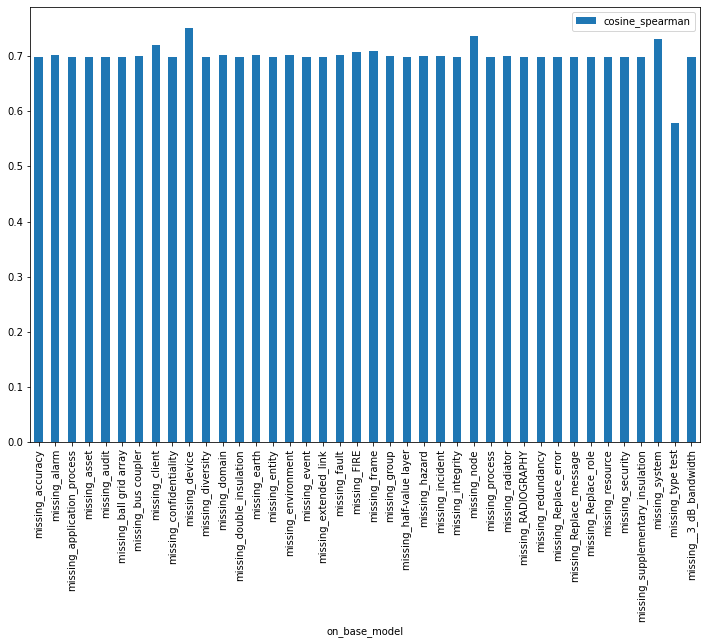

In [18]:
from pandas import read_csv
import pandas

file = "plots/Influence of each term and varied threshold/With_missing_terms_new2_on_base_model.csv"
col_list = ["cosine_spearman"]
dataframe = read_csv(file, usecols=col_list)


x_axis = []
dataset_dir = 'datasets/removed/'
for subdir1, dirs1, files1 in os.walk(dataset_dir):
    if subdir1 != dataset_dir and not subdir1.endswith(".ipynb_checkpoints"):
        directory = dataset_dir+subdir1[17:]+"/"+"gold_dataset.tsv"  
        x_axis.append(str(subdir1[17:]))

        
df=pandas.concat([dataframe, pd.DataFrame(x_axis, columns=['on_base_model'])],axis=1)
# df.to_csv("plots/Influence of each term and varied threshold/plot_values_new2.csv")
fig=df.plot.bar(x='on_base_model', y='cosine_spearman',figsize=(12, 8), rot=90).get_figure()
fig.savefig("plots/Influence of each term and varied threshold/plot10_on_base_model.jpg",bbox_inches='tight')


In [ ]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os
import gzip
import csv

def evaluate(dataset_path, threshold, trained_model='fine-tuned_model/fine-tuning-distilroberta-base-paraphrase-v1-2021-05-10_14-17-46'):
    train_samples = []
    dev_samples = []
    test_samples = []

    with open(dataset_path, 'rt', encoding='utf8') as fIn:
        reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            if row['score'] == "1":
                score = 1
            elif row['score'] == "A":
                score = 0.8
            elif row['score'] == "B":
                score = 0.6
            elif row['score'] == "C":
                score = 0.4
            else: score = 0
                
            if score >= threshold:
                score = 1
            else: score = 0

            inp_example = InputExample(texts=[str(row['sentence1']), str(row['sentence2'])], label=score)

            test_samples.append(inp_example)


    ##############################################################################
    #
    # Load the model and evaluate its performance on test dataset
    #
    ##############################################################################
    model = SentenceTransformer('distilroberta-base-paraphrase-v1')
    test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='test')
    test_evaluator(model, output_path=trained_model)


dataset_dir = 'datasets/gold_dataset.tsv'

for threshold in np.arange(0.2, 0.9, 0.05):
    evaluate(dataset_dir, threshold)
        

In [ ]:
from pandas import read_csv
import pandas

file = "plots/varied_threshold_on_base_model.csv"
col_list = ["cosine_spearman"]
dataframe = read_csv(file, usecols=col_list)


x_axis = []
dataset_dir = 'datasets/removed/'
for threshold in np.arange(0.2, 0.9, 0.05): 
    x_axis.append(threshold)

        
df=pandas.concat([dataframe, pd.DataFrame(x_axis, columns=['threshold (evaluation on base model)'])],axis=1)
df.to_csv("plots/plot4_values.csv")
fig=df.plot(x='threshold (evaluation on base model)', y='cosine_spearman',figsize=(12, 8), rot=90).get_figure()
fig.savefig("plots/plot4_on_base_model.jpg",bbox_inches='tight')

In [ ]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os
import gzip
import csv
import pandas as pd

def evaluate(dataset_path, trained_model='fine-tuned_model/fine-tuning-distilroberta-base-paraphrase-v1-2021-05-10_14-17-46'):
    train_samples = []
    dev_samples = []
    test_samples = []
    
    newdf = pd.DataFrame(columns=['sentence1','sentence2','split','score','finetuned_model_sim','base_model_sim'])
    model = SentenceTransformer(trained_model)
    model1 = SentenceTransformer('distilroberta-base-paraphrase-v1')
    with open(dataset_path, 'rt', encoding='utf8') as fIn:
        reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)

        for row in reader:
            if row['score'] == "1":
                score = 1
            elif row['score'] == "A":
                score = 0.8
            elif row['score'] == "B":
                score = 0.6
            elif row['score'] == "C":
                score = 0.4
            else: score = 0

            #inp_example = InputExample(texts=[str(row['sentence1']), str(row['sentence2'])], label=score)

            #test_evaluator = EmbeddingSimilarityEvaluator(sentences1=[str(row['sentence1'])], sentences2=[str(row['sentence2'])], scores=[score])
            #test_evaluator(model, output_path=trained_model)
            embed=model.encode([str(row['sentence1']), str(row['sentence2'])])
            embed1=model1.encode([str(row['sentence1']), str(row['sentence2'])])
            cosine_score = util.pytorch_cos_sim(embed[0], embed[1])
            cosine_score1 = util.pytorch_cos_sim(embed1[0], embed1[1])
            df = pd.DataFrame([[row['sentence1'], row['sentence2'], row['split'], score, float(cosine_score), float(cosine_score1)]], columns=['sentence1','sentence2','split','score','finetuned_model_sim','base_model_sim'])
            newdf=pandas.concat([newdf, df], ignore_index=True)
     
    newdf.to_csv('datasets/gold_dataset1.tsv', index=False)


dataset_dir = 'datasets/gold_dataset.tsv'

evaluate(dataset_dir)
    

In [ ]:
from pandas import read_excel
import numpy as np
import pandas as pd
import os

# Number of pairs
dataset_size = 7000

rootdir = 'datasets_labeled/removed/'
generated_dataset_dir = 'datasets/removed/'

for [subdir, dirs, files], [subdir1, dirs1, files1] in zip(os.walk(rootdir), os.walk(generated_dataset_dir)):
    if subdir != rootdir and subdir1 != generated_dataset_dir and not subdir1.endswith(".ipynb_checkpoints"):
        directory = subdir+"/"
        print(subdir[0:25]+subdir1[17:])
        
        loc_generated_devset = generated_dataset_dir + "/dev_set.csv"
        loc_generated_trainset = generated_dataset_dir + "/train_set.csv"
        loc_generated_testset = generated_dataset_dir + "/test_set.csv"